<a href="https://colab.research.google.com/github/hypro2/step-by-step-multimodal/blob/main/LLaVA_13b_4bit_vanilla_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):

    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')

    else:
        image = Image.open(image_file).convert('RGB')

    disable_torch_init()

    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles

    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()

    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp

    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)

    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])

    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1960 (delta 615), reused 568 (delta 568), pack-reused 1267
Receiving objects: 100% (1960/1960), 13.32 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (1214/1214), done.
/content/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 12.0 MB/s eta 0:00:00
     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [2]:
"""이 특허는 높은 집적도와 성능을 위한 화이트 게이트 구조와 수직 패턴을 갖는 반도체 소자에 대해 설명합니다.
이 소자는 전기적 특성을 개선하고 수직 채널 영역에서 게이트 전극의 제어 가능성을 줄이기 위해 에어 갭이 있는 유전체 구조를 포함합니다.
이 소자는 또한 메모리 애플리케이션을 위한 후면 게이트 트렌치, 접촉 패턴 및 정보 저장 구조를 특징으로 합니다.
상기 제조 공정은 상기 화이트 게이트 구조, 수직 패턴 및 게이트 유전체 층을 형성하고, 상기 반도체 기판 내에 접촉 홀 및 후면 게이트 트렌치를 생성하는 단계를 포함합니다.
전반적으로, 이 특허는 고집적 및 향상된 전기적 특성을 달성하기 위한 반도체 소자의 설계 및 제조 방법을 자세히 설명합니다.

그림 1은 예시적인 실시 예에 따른 반도체 소자의 개략적인 평면도입니다."""

'이 특허는 높은 집적도와 성능을 위한 화이트 게이트 구조와 수직 패턴을 갖는 반도체 소자에 대해 설명합니다.\n이 소자는 전기적 특성을 개선하고 수직 채널 영역에서 게이트 전극의 제어 가능성을 줄이기 위해 에어 갭이 있는 유전체 구조를 포함합니다.\n이 소자는 또한 메모리 애플리케이션을 위한 후면 게이트 트렌치, 접촉 패턴 및 정보 저장 구조를 특징으로 합니다.\n상기 제조 공정은 상기 화이트 게이트 구조, 수직 패턴 및 게이트 유전체 층을 형성하고, 상기 반도체 기판 내에 접촉 홀 및 후면 게이트 트렌치를 생성하는 단계를 포함합니다.\n전반적으로, 이 특허는 고집적 및 향상된 전기적 특성을 달성하기 위한 반도체 소자의 설계 및 제조 방법을 자세히 설명합니다.\n\n그림 1은 예시적인 실시 예에 따른 반도체 소자의 개략적인 평면도입니다.'

In [3]:
txt ="""```This patent describes a semiconductor device having a white gate structure and vertical pattern for high integration and performance.
It includes a dielectric structure with air gaps to improve electrical properties and reduce controllability of the gate electrodes over the vertical channel region.
The device further features a back gate trench, a contact pattern, and an information storage structure for memory applications.
Said fabrication process includes forming said white gate structure, vertical pattern, and gate-dielectric layer, and creating contact holes and back gate trenches within said semiconductor substrate.
Overall, the patent details methods for designing and manufacturing semiconductor devices to achieve high integration and improved electrical characteristics.

FIG. 1 is a schematic plan view of a semiconductor device, according to exemplary embodiments.
103
Intermediate Insulation Layer
107a
Third Upper Insulation Layer
130
Back Gate Structure
132
Dielectric Structures
135
Back Gate Electrodes
137
First and Second Auxiliary Structures
137a
First Floor
137b
Second Floor
140
Vertical Pattern
140S1
1st Side
162
Gate Dielectric Layer
165
Gate Electrode
166
Gate Capping Layer
```

Let's work this out in a step by step way to be sure we have the right answer.
It describes the image in considerable detail."""

The image shows a semiconductor device with a white gate structure and vertical pattern, which is designed for high integration and performance. The device features a dielectric structure with air gaps to improve electrical properties and reduce controllability of the gate electrodes over the vertical channel region.

The semiconductor device also includes a back gate trench, a contact pattern, and an information storage structure for memory applications. The fabrication process involves forming the white gate structure, vertical pattern, and gate-dielectric layer, as well as creating contact holes and back gate trenches within the semiconductor substrate.

In the image, there are several numbers and labels, which are likely used to indicate specific components or dimensions of the device. The overall purpose of the patent is to detail methods for designing and manufacturing semiconductor devices to achieve high integration and improved electrical characteristics.


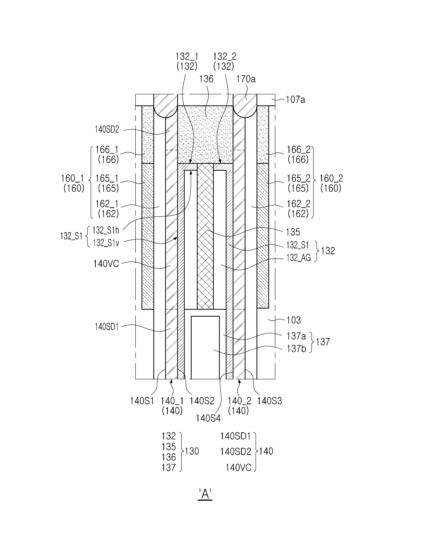

In [4]:
image, output = caption_image(f'/content/sdfsdfsdfdsf.jpg', txt)
print(output)
image

In [ ]:
"""이 이미지는 높은 집적도와 성능을 위해 설계된 흰색 게이트 구조와 수직 패턴을 가진 반도체 소자를 보여줍니다.
이 소자는 전기적 특성을 개선하고 수직 채널 영역에서 게이트 전극의 제어 가능성을 줄이기 위해 에어 갭이 있는 유전체 구조를 갖추고 있습니다.
이 반도체 소자는 또한 메모리 애플리케이션을 위한 후면 게이트 트렌치, 접촉 패턴 및 정보 저장 구조를 포함합니다.
제조 공정에는 화이트 게이트 구조, 수직 패턴, 게이트 유전체 층을 형성하고 반도체 기판 내에 접촉 홀과 후면 게이트 트렌치를 만드는 작업이 포함됩니다.
이미지에는 여러 개의 숫자와 레이블이 있는데, 이는 장치의 특정 구성 요소나 치수를 나타내는 데 사용되는 것으로 보입니다.
이 특허의 전반적인 목적은 고집적도와 향상된 전기적 특성을 달성하기 위해 반도체 장치를 설계하고 제조하는 방법을 자세히 설명하는 것입니다."""

In [6]:
model

LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm(